# Muscle Arm RNN Control

A biologically-inspired neural network controller for a MuJoCo muscle-driven arm.

## Architecture
- **Proprioceptive Module**: Type Ia (velocity), Type II (length), Type Ib (force) - single ReLU per muscle
- **Target Encoding**: Gaussian-tuned spatial grid - single ReLU layer
- **RNN**: Recurrent integration with alpha MN feedback
- **Output Module**: Alpha MNs + Gamma static/dynamic - single ReLU each
- **Reflex Pathways**: Direct Ia→Alpha and II→Alpha connections

In [1]:
# Setup path
import sys
sys.path.insert(0, '.')  # Adjust if notebook is not in project root

# Core imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Model Information

Parse the MuJoCo XML to see what's in the model.

In [2]:
from utils.model_parser import parse_mujoco_xml, get_model_dimensions

XML_PATH = 'arm.xml'  # <-- Adjust path to your XML file

parsed = parse_mujoco_xml(XML_PATH)
dims = get_model_dimensions(parsed)

print(f"Model: {parsed.model_name}")
print(f"Timestep: {parsed.timestep}s")
print(f"\nJoints ({parsed.n_joints}):")
for j in parsed.joints:
    print(f"  - {j.name}: {j.joint_type}, range={j.range}")

print(f"\nMuscles ({parsed.n_muscles}):")
for m in parsed.muscles:
    print(f"  - {m.name}: force={m.force}N")

print(f"\nSensors ({parsed.n_sensors}):")
for s in parsed.sensors:
    print(f"  - {s.name}: {s.sensor_type}")

print(f"\nNetwork Dimensions:")
for k, v in dims.items():
    print(f"  {k}: {v}")

ModuleNotFoundError: No module named 'envs.reaching_env'

## 2. Sensor Calibration

Run random episodes to gather sensor statistics for normalization.

In [ ]:
from envs.reaching_env import calibrate_sensors, ReachingEnv

# Run calibration (takes ~30 seconds)
print("Calibrating sensors...")
sensor_stats = calibrate_sensors(XML_PATH, n_episodes=50, max_steps_per_episode=200)

print("\nSensor Statistics:")
for k, v in sensor_stats.items():
    print(f"  {k}: {v}")

# Save for later use
with open('sensor_stats.pkl', 'wb') as f:
    pickle.dump(sensor_stats, f)
print("\nSaved to sensor_stats.pkl")

Calibrating sensors...

Sensor Statistics:
  length_mean: [0.24090674 0.24965797 0.36015012 0.41196938]
  length_std: [0.03649931 0.03595599 0.02927957 0.02294587]
  velocity_mean: [ 0.00277263 -0.00155721 -0.01208307  0.00824345]
  velocity_std: [0.02253187 0.02219845 0.03687901 0.02890152]
  force_mean: [-50.91593112 -51.56766977 -44.20152678 -54.1612127 ]
  force_std: [12.67954579 12.65454322 10.21999094 12.81586753]

Saved to sensor_stats.pkl


## 3. Test Environment

In [ ]:
# Create environment
env = ReachingEnv(XML_PATH, sensor_stats=sensor_stats)

print(f"Observation space: {env.observation_space.shape}")
print(f"Action space: {env.action_space.shape}")

# Run a test episode with random actions
obs, info = env.reset()
print(f"\nInitial info: {info}")

total_reward = 0
for step in range(200):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if step % 50 == 0:
        print(f"Step {step}: phase={info['phase']}, distance={info['distance_to_target']:.3f}")
    
    if terminated or truncated:
        break

print(f"\nEpisode finished after {step+1} steps, total reward: {total_reward:.2f}")
env.close()

Observation space: (41,)
Action space: (12,)

Initial info: {'target_position': array([-0.26312868, -0.21865773,  0.03215066]), 'initial_joints': array([0.36936173, 0.51285731]), 'pre_delay': 0.4834606554568429, 'hold_duration': 0.7773715202232601}
Step 0: phase=pre_delay, distance=0.437
Step 50: phase=reach, distance=0.446
Step 100: phase=reach, distance=0.435
Step 150: phase=reach, distance=0.413

Episode finished after 200 steps, total reward: -66.33


## 4. Create Controller

Initialize the RNN controller and inspect its architecture.

In [ ]:
from models.controllers import ModelConfig, RNNController, MLPController

# Create config
config = ModelConfig(
    n_muscles=parsed.n_muscles,
    n_joints=parsed.n_joints,
    n_target_units=16,  # 4x4 grid
    rnn_hidden_size=32,
    rnn_type='rnn',  # 'rnn', 'gru', or 'lstm'
    n_rnn_layers=1,
)

print(f"Config:")
print(f"  n_muscles: {config.n_muscles}")
print(f"  total_input_dim: {config.total_input_dim}")
print(f"  total_output_dim: {config.total_output_dim}")

# Create controller
controller = RNNController(config)
print(f"\nRNN Controller: {controller.count_parameters():,} parameters")

# Test forward pass
batch_size = 1
obs_tensor = torch.randn(batch_size, config.total_input_dim)
controller.init_hidden(batch_size, obs_tensor.device)

action, hidden, info = controller.forward(obs_tensor)
print(f"\nTest forward pass:")
print(f"  Input: {obs_tensor.shape}")
print(f"  Output: {action.shape}")
print(f"  Alpha: {info['alpha'].shape}")
print(f"  Gamma static: {info['gamma_static'].shape}")
print(f"  Gamma dynamic: {info['gamma_dynamic'].shape}")

Config:
  n_muscles: 4
  total_input_dim: 32
  total_output_dim: 12

RNN Controller: 4,020 parameters

Test forward pass:
  Input: torch.Size([1, 32])
  Output: torch.Size([1, 12])
  Alpha: torch.Size([1, 4])
  Gamma static: torch.Size([1, 4])
  Gamma dynamic: torch.Size([1, 4])


## 5. Inspect Weights (Before Training)

In [ ]:
from utils.visualization import (
    print_weight_summary, 
    plot_sensory_weights, 
    plot_reflex_connections,
    plot_weight_distributions
)

# Print weight summary
print_weight_summary(controller)


Network Weight Summary
Layer                                         Shape                    Mean      Std Sparsity
--------------------------------------------------------------------------------
proprioceptive.type_Ia.0.weight               (1, 1)                 0.9132   0.0000    0.00%
proprioceptive.type_Ia.0.bias                 (1,)                   0.0000   0.0000  100.00%
proprioceptive.type_Ia.1.weight               (1, 1)                 0.5983   0.0000    0.00%
proprioceptive.type_Ia.1.bias                 (1,)                   0.0000   0.0000  100.00%
proprioceptive.type_Ia.2.weight               (1, 1)                 1.1536   0.0000    0.00%
proprioceptive.type_Ia.2.bias                 (1,)                   0.0000   0.0000  100.00%
proprioceptive.type_Ia.3.weight               (1, 1)                 0.9555   0.0000    0.00%
proprioceptive.type_Ia.3.bias                 (1,)                   0.0000   0.0000  100.00%
proprioceptive.type_II.0.weight               (1,

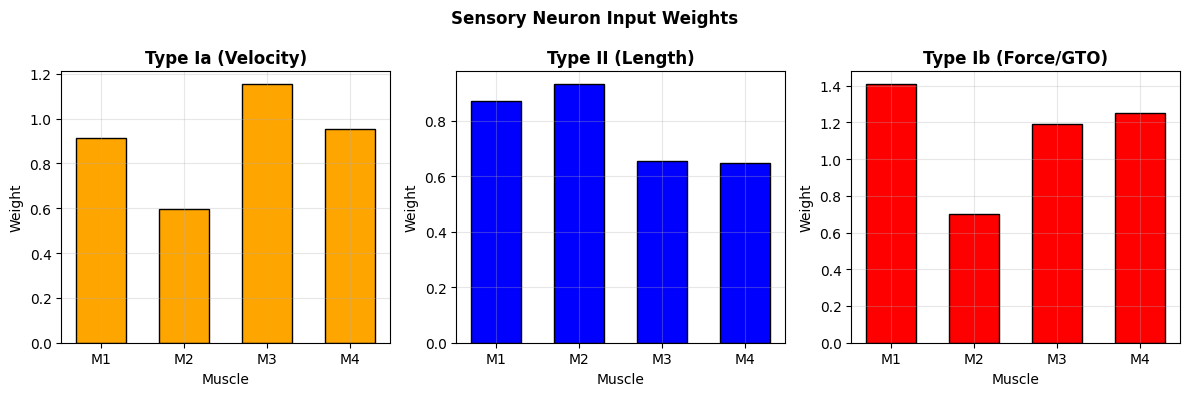

In [ ]:
# Plot sensory neuron weights
plot_sensory_weights(controller)

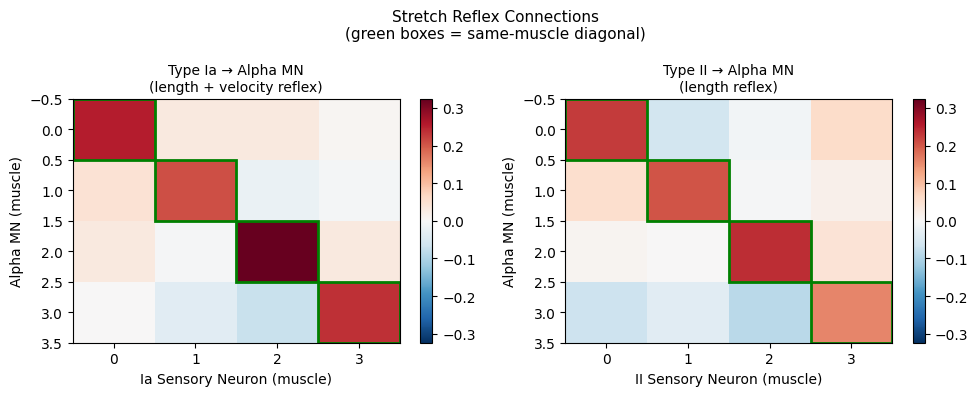

In [ ]:
# Plot reflex connections (Ia->Alpha, II->Alpha)
plot_reflex_connections(controller)

## 6. Training with CMA-ES

Use evolutionary optimization to train the controller.

In [ ]:
from training.train_cmaes import run_cmaes_training

# Train (this takes a while - reduce generations for quick test)
# NOTE: use_multiprocessing=False is required for notebooks/Windows
results = run_cmaes_training(
    xml_path=XML_PATH,
    output_dir='outputs/cmaes',
    n_generations=100,  # Increase for better results (500+)
    population_size=32,  # Increase for better exploration (64+)
    use_multiprocessing=False,  # Must be False for notebooks
    calibration_episodes=30,
)

print(f"\nTraining complete!")
print(f"Best fitness: {results['best_fitness']:.3f}")
print(f"Generations: {results['generations']}")

Model: planar-arm
Joints: 2
Muscles: 4
Calibrating sensors...
Controller has 4020 parameters
Starting CMA-ES training for 100 generations
Population size: 32
Parallel workers: 1 (sequential)


Gen 0: best=-10.618, mean=-66.671, sigma=0.0997, time=146.7s


Gen 1:  84%|████████▍ | 27/32 [01:47<00:20,  4.06s/it]

## 7. Training with Distillation

Alternative: Train MLP teacher first, then distill to RNN student.

In [ ]:
from training.train_distillation import run_distillation_training

# Train via distillation
results = run_distillation_training(
    xml_path=XML_PATH,
    output_dir='outputs/distillation',
    teacher_epochs=50,   # Increase for better teacher
    student_epochs=100,  # Increase for better student
    calibration_episodes=30
)

print(f"\nTraining complete!")
print(f"Teacher success rate: {results['teacher_success_rate']:.2%}")
print(f"Student success rate: {results['student_success_rate']:.2%}")

## 8. Load and Evaluate Trained Controller

In [ ]:
from utils.visualization import load_controller, evaluate_controller

# Load trained controller
CHECKPOINT_PATH = 'outputs/cmaes/best_controller_final.pt'  # <-- Adjust path

controller, config, checkpoint = load_controller(CHECKPOINT_PATH)
print(f"Loaded controller with {controller.count_parameters():,} parameters")
if 'fitness' in checkpoint:
    print(f"Training fitness: {checkpoint['fitness']:.3f}")

# Load sensor stats
stats_path = Path(CHECKPOINT_PATH).parent / 'sensor_stats.pkl'
with open(stats_path, 'rb') as f:
    sensor_stats = pickle.load(f)

In [ ]:
# Evaluate
results = evaluate_controller(
    controller=controller,
    xml_path=XML_PATH,
    sensor_stats=sensor_stats,
    n_episodes=50,
    max_steps=300
)

print(f"\nEvaluation Results:")
print(f"  Success Rate: {results['success_rate']:.2%}")
print(f"  Mean Reward: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}")
print(f"  Mean Episode Length: {results['mean_length']:.1f} steps")

## 9. Inspect Trained Weights

In [ ]:
# Weight summary
print_weight_summary(controller)

In [ ]:
# Sensory weights after training
plot_sensory_weights(controller)

In [ ]:
# Reflex connections after training
plot_reflex_connections(controller)

In [ ]:
# All weight distributions
plot_weight_distributions(controller, figsize=(16, 10))

## 10. Episode Summary Analysis

In [ ]:
from utils.visualization import record_episode, plot_episode_summary, plot_trajectory

# Record an episode
trajectory = record_episode(
    controller=controller,
    xml_path=XML_PATH,
    sensor_stats=sensor_stats,
    max_steps=300
)

total_reward = sum(trajectory['rewards'])
final_phase = trajectory['infos'][-1].get('phase', 'unknown')
print(f"Episode: {len(trajectory['rewards'])} steps, reward={total_reward:.2f}, phase={final_phase}")

In [ ]:
# Plot comprehensive episode summary
# Shows: sensor data, target encoding, hand kinematics, reward components
plot_episode_summary(trajectory, figsize=(16, 14))

In [ ]:
# Plot detailed motor outputs
plot_trajectory(trajectory)

## 11. Network Activity Visualization

Visualize network activity during simulation with units as colored circles.

In [ ]:
from utils.network_visualizer import NetworkActivityVisualizer, record_episode_with_network

# Record episode with network visualization
trajectory = record_episode_with_network(
    controller=controller,
    xml_path=XML_PATH,
    sensor_stats=sensor_stats,
    max_steps=300,
    output_video='network_activity.mp4',  # Set to None to skip video
    fps=30,
    layout='horizontal'  # 'horizontal', 'vertical', or 'overlay'
)

print(f"Episode: {len(trajectory['rewards'])} steps")
print(f"Video saved to network_activity.mp4")

In [ ]:
# Display a single frame from the visualization
if trajectory['combined_frames']:
    # Show frame at step 100 (or last frame)
    frame_idx = min(100, len(trajectory['combined_frames']) - 1)
    plt.figure(figsize=(16, 8))
    plt.imshow(trajectory['combined_frames'][frame_idx])
    plt.axis('off')
    plt.title(f'Network Activity at Step {frame_idx}')
    plt.show()

## 12. Full Checkpoint Inspection

Generate all plots and analyses in one go.

In [ ]:
from utils.visualization import inspect_checkpoint

# Full inspection: weights + episode analysis
inspect_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    xml_path=XML_PATH,
    output_dir='inspection/',
    n_episodes=3,
    max_steps=300,
    show=True  # Set to False to just save plots
)

## 13. Compare Controllers

Compare multiple trained controllers (e.g., CMA-ES vs Distillation).

In [ ]:
from utils.visualization import compare_controllers

# Compare different checkpoints
results = compare_controllers(
    controller_paths=[
        'outputs/cmaes/best_controller_final.pt',
        'outputs/distillation/student_rnn.pt',
    ],
    labels=['CMA-ES', 'Distillation'],
    xml_path=XML_PATH,
    sensor_stats=sensor_stats,
    n_episodes=30
)